In [ ]:
#IMPORTS

In [1]:
!pip install numpy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
from mosplot.plot import load_lookup_table, Mosfet, Expression

In [3]:
lookup_table = load_lookup_table("/home/just/Desktop/teste3/gmid-main/tests/lookup_table_generator/tsm65nm/tsmc65nm_V4.npz")

In [4]:
print(lookup_table.keys())

dict_keys(['nch_mac', 'pch_mac', 'description', 'simulator', 'parameter_names', 'device_parameters'])


In [5]:
#Making Simple Plots

In [6]:
nmos = Mosfet(lookup_table=lookup_table, mos="nch_mac", vbs=0.0, vds=0.6, vgs=(0.2, 1.2))
pmos = Mosfet(lookup_table=lookup_table, mos="pch_mac", vbs=0.0, vds=-0.6, vgs=(-1.2, -0.2))

In [7]:
print(nmos.length)

[6.00e-08 6.50e-08 7.00e-08 7.50e-08 8.00e-08 8.50e-08 9.00e-08 9.50e-08
 1.00e-07 1.05e-07 1.10e-07 1.15e-07 1.20e-07 1.80e-07 2.40e-07 3.00e-07
 3.60e-07 4.20e-07 4.80e-07 5.40e-07 6.00e-07 6.60e-07 7.20e-07 7.80e-07
 8.40e-07 9.00e-07 9.60e-07 1.02e-06 1.08e-06 1.14e-06]


In [8]:
try:
    result = pmos.interpolate(
        x_expression=pmos.length_expression,
        x_value=150e-9,  # Test value
        y_expression=pmos.gmid_expression,
        y_value=10,      # Test value
        z_expression=pmos.current_density_expression,
        fast=True
    )
    print("fast=True works! Result:", result)
except Exception as e:
    print("fast=True failed:", e)

result = pmos.interpolate(
        x_expression=pmos.length_expression,
        x_value=150e-9,  # Test value
        y_expression=pmos.gmid_expression,
        y_value=10,      # Test value
        z_expression=pmos.current_density_expression,
        fast=True
    )
print(result)

fast=True works! Result: [11.59517781]
[11.59517781]


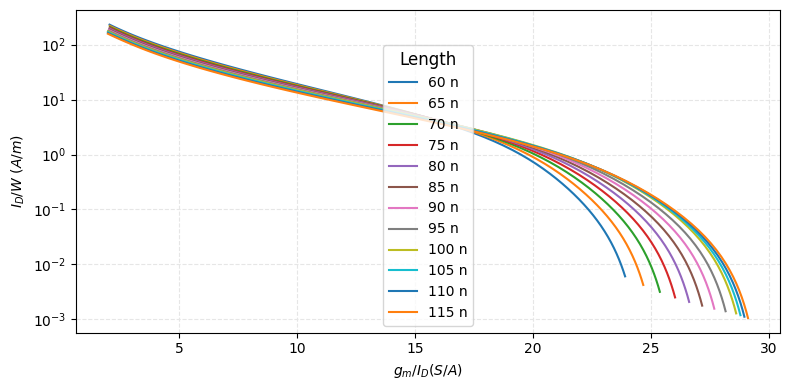

vgs3= [0.50892171]
vsg4= [0.61894007]


In [25]:
pmos.plot_by_expression(
    y_expression = pmos.current_density_expression,
    x_expression = Expression(
        variables=["gm", "id"], 
        function=lambda x, y: x / (y),
        label="$g_m/I_D (S/A)$",
        ),
    filtered_values = pmos.length[0:12:1],
    y_scale="log",
    save_fig="/home/just/Desktop/gmID_OTA-main/images/pmos_current_density2.png",
)

vb1 =  nmos.interpolate(
        x_expression=nmos.length_expression,
        x_value=200e-9,
        y_expression=nmos.gmid_expression,
        y_value=15.2,
        z_expression=pmos.vgs_expression
)
print("vgs3=",vb1)

vb2 =  pmos.interpolate(
        x_expression=pmos.length_expression,
        x_value=150e-9,
        y_expression=pmos.gmid_expression,
        y_value=10.3,
        z_expression=pmos.vsg_expression
)
print("vsg4=",vb2)

In [9]:
import numpy as np
from scipy import constants
from dataclasses import dataclass
from typing import Optional
#
# Constants
k = constants.Boltzmann
TEMP = 300  # Kelvin

# --------------------------------------------
# Data Structures
# --------------------------------------------
@dataclass
class Specs:
    """Design specifications"""
    ts: float         # Settling time (s)
    fu1: float        # Unity gain freq (Hz)
    fp2: float        # Non-dominant pole (Hz)
    vod_noise: float  # Input-referred noise (V)
    G: float          # Closed-loop gain
    FO: float         # Fan-out
    L0: float         # Open-loop gain spec

@dataclass
class DesignParams:
    """Assumed parameters"""
    beta: float = None         # Will be computed as 0.75*beta_max
    beta_max: float = None     # Derived from G when not provided
    slew_frac: float = None     # Slew fraction of ts
    rself1: float = None        # Self-loading factor stage 1
    rself2: float = None        # Self-loading factor stage 2
    cgs2_cc: float = None       # Cgs2/CC ratio
    cltot_cc: float = None      # CLtot/CC initial assumption
    gm3_gm1: float = None       # M3/M1 gm ratio
    gm4_gm2: float = None       # M4/M2 gm ratio
    gam1: float = None          # Noise coeff M1
    gam2: float = None          # Noise coeff M2
    gam3: float = None          # Noise coeff M3
    gam4: float = None          # Noise coeff M4
    L1:float=None
    L2:float=None
    L3:float=None
    L4:float=None

@dataclass
class Transistor:
    L: float                    # Channel length [m]
    # Design variables
    gm: Optional[float] = None  # Transconductance [S]
    id: Optional[float] = None  # Drain current [A]
    gm_id: Optional[float] = None  # gm/ID ratio [S/A]
    w: Optional[float] = None   # Width [m]
    ft: Optional[float] = None 
    # Capacitances
    cgg: Optional[float] = None  # Total gate cap [F]
    cgs: Optional[float] = None  # Gate-source cap [F]
    cgd: Optional[float] = None  # Gate-drain cap [F]
    cdd: Optional[float] = None  # Total drain cap [F]
    

@dataclass
class Circuit:
    """Circuit components"""
    cc: Optional[float] = None
    cltot: Optional[float] = None
    cf: Optional[float] = None
    cs: Optional[float] = None
    cl: Optional[float] = None
    c1: Optional[float] = None
    rz: Optional[float] = None
    cn: Optional[float] = None
    cc_add: Optional[float] = None


In [10]:
def calculate_capacitances(specs: Specs, params: DesignParams, m2: Transistor) -> Circuit:
    circuit = Circuit()
    kT = k * TEMP
    
    # Auto-compute beta if not provided
    if params.beta_max is None:
        params.beta_max = 1 / (1 + specs.G)
    if params.beta is None:
        params.beta = 0.75 * params.beta_max
    
    # Noise-derived CC calculation 
    numerator = (2/params.beta * kT * params.gam1 * (1 + params.gam3/params.gam1 * params.gm3_gm1) + 
                1/params.cltot_cc * kT * (1 + params.gam2 * (1 + params.gam4/params.gam2 * params.gm4_gm2)))
    #numerator=(2*kT)*(((1/params.beta)*params.gam1*(1+ (params.gam3/params.gam1)*params.gm3_gm1))+(1+params.gam2*(1+(params.gam4/params.gam2)*params.gm4_gm2)))
    circuit.cc = numerator / (specs.vod_noise ** 2)
    # Downstream capacitances
    circuit.cltot = circuit.cc * params.cltot_cc #cltot=cc
    #circuit.cf = circuit.cltot / (1 + params.rself2) / (1 - params.beta + specs.FO * specs.G)
    circuit.cf = circuit.cltot / ((1 + params.rself2)*(1 - params.beta + specs.FO * specs.G))
    circuit.cs = circuit.cf * specs.G
    circuit.cl = circuit.cs * specs.FO

    m2.cgs = circuit.cc * params.cgs2_cc  # cgs2_cc=1/3
    circuit.c1 = m2.cgs * (1 + params.rself1)  
    
    return circuit

In [11]:
def calculate_m1_parameters(m1: Transistor, specs: Specs, params: DesignParams, circuit: Circuit) -> Transistor:
    """Calculate M1 parameters 
    
    Args:
        m1: Pre-initialized transistor with L and PDK parameters
        specs: Design specifications
        params: Design parameters
        circuit: Calculated circuit components
        
    Returns:
        Configured M1 transistor with all calculated parameters
    """
    # Calculate gmR 
    gmR = np.sqrt(specs.L0) / params.beta #possivelmente os valores de teste sao demasiado elevados (rever)
    # Transconductance calculation 
    m1.gm = (2 * np.pi * specs.fu1 * circuit.cc / params.beta * 
            (1 + (1 + circuit.c1/circuit.cc)/gmR + 
             (1 + circuit.cltot/circuit.cc)/gmR))
    
    # Gate capacitance 
    m1.cgg = circuit.cf * ((1/params.beta) - 1 - specs.G)
    
    # Transition frequency
    m1.ft = m1.gm / m1.cgg / (2 * np.pi)
    
    # gm/ID lookup 
    m1.gm_id=pmos.interpolate(
        x_expression=pmos.length_expression,
        x_value=m1.L,
        y_expression = Expression(
        variables=["gm", "cgg"],
        function=lambda x, y: x / y,
        ),
        y_value=m1.gm/m1.cgg,
        z_expression=pmos.gmid_expression,
        fast=True
    ).item() 

    # Drain current
    m1.id = m1.gm / m1.gm_id
    
    return m1

In [12]:
def calculate_m2_parameters(m2: Transistor, specs: Specs, params: DesignParams, circuit: Circuit) -> Transistor:
    """Calculate M2 parameters 
    
    Args:
        m2: Pre-initialized transistor with L and cgs parameters
        specs: Design specifications
        params: Design parameters
        circuit: Calculated circuit components
        
    Returns:
        Configured M2 transistor with all calculated parameters
    """
    # 1. Transconductance calculation 
    m2.gm = (2 * np.pi * specs.fp2 * 
            (1 + circuit.cltot/circuit.cc + circuit.cltot/circuit.c1) * 
            circuit.c1)
    
    # 2. Transition frequency 
    m2.ft = m2.gm / m2.cgs / (2 * np.pi)
    
    # 3. gm/ID lookup 
    m2.gm_id=nmos.interpolate(
        x_expression=nmos.length_expression,
        x_value=m2.L,
        y_expression = Expression(
        variables=["gm", "cgg"],#Rever isto 
        function=lambda x, y: x / (y),
        ),
        y_value=m2.gm/m2.cgs,
        z_expression=nmos.gmid_expression,
        fast=True
    ).item()
    
    # 4. Drain current
    m2.id = m2.gm / m2.gm_id
    
    # 5. Nulling resistor (MATLAB: p.rz = 1./m2.gm)
    circuit.rz = 1 / m2.gm
    
    return m2

In [13]:
def calculate_transistor_widths(m1: Transistor, m2: Transistor, 
                               m3: Transistor, m4: Transistor,
                               params: DesignParams) -> None:
    """Calculate transistor widths 
    
    Args:
        m1: Input pair transistor
        m2: Second stage transistor
        m3: PMOS mirror for M1
        m4: PMOS mirror for M2
        params: Design parameters with gm ratios
    """
    # 1. Set current mirror gm/ID ratios 
    m3.gm_id = m1.gm_id * params.gm3_gm1  
    m4.gm_id = m2.gm_id * params.gm4_gm2  
    
    # 2. Calculate widths using current density (ID/W)
    m1.w = m1.id / pmos.interpolate(
        x_expression=pmos.length_expression,
        x_value=m1.L,
        y_expression=pmos.gmid_expression,
        y_value=m1.gm_id,
        z_expression=pmos.current_density_expression,
        fast=True
    ).item() 

    m2.w = m2.id / nmos.interpolate(
        x_expression=nmos.length_expression,
        x_value=m2.L,
        y_expression=nmos.gmid_expression,
        y_value=m2.gm_id,
        z_expression=nmos.current_density_expression,
        fast=True
    ).item() 

    # 3. Mirror devices inherit currents but have their own gm/ID
    m3.w = m1.id / nmos.interpolate(
        x_expression=nmos.length_expression,
        x_value=m3.L,
        y_expression=nmos.gmid_expression,
        y_value=m3.gm_id,
        z_expression=nmos.current_density_expression,
        fast=True
    ).item() 

    m4.w = m2.id / pmos.interpolate(
        x_expression=pmos.length_expression,
        x_value=m4.L,
        y_expression=pmos.gmid_expression,
        y_value=m4.gm_id,
        z_expression=pmos.current_density_expression,
        fast=True
    ).item() 

In [14]:
def calculate_compensation_caps(m1: Transistor, m2: Transistor, circuit: Circuit) -> None:
    """Calculate neutralization and compensation caps
    
    Args:
        m1: Input pair transistor
        m2: Second stage transistor
        circuit: Circuit components (updates cn and cc_add)
    """
    # 1. M1 gate-drain capacitance (neutralization cap)
    m1.cgd =m1.w*pmos.interpolate(
        x_expression=pmos.length_expression,
        x_value=m1.L,
        y_expression=pmos.gmid_expression,
        y_value=m1.gm_id,
        z_expression=Expression(
            variables=["cgd", "weff"],
            function=lambda x, y: x / (y),
        ),
        fast=True
    ).item()
    
    # 2. Set neutralization cap 
    circuit.cn = m1.cgd
    
    # 3. M2 gate-drain capacitance
    m2.cgd =m2.w*nmos.interpolate(
        x_expression=nmos.length_expression,
        x_value=m2.L,
        y_expression=nmos.gmid_expression,
        y_value=m2.gm_id,
        z_expression=Expression(
            variables=["cgd", "weff"],
            function=lambda x, y: x / (y),
        ),
        fast=True
    ).item() 
    
    # 4. Additional compensation cap 
    circuit.cc_add = circuit.cc - m2.cgd

In [15]:
def calculate_self_loading(m1: Transistor, m2: Transistor, 
                         m3: Transistor, m4: Transistor,
                         circuit: Circuit, params: DesignParams) -> None:
    """Calculate self-loading effects 
    
    Args:
        m1-m4: All transistors with calculated widths
        circuit: Circuit components (updates rself1/rself2)
        params: Design parameters (beta)
    """
    # 1. Drain capacitances
    m1.cdd = m1.w*pmos.interpolate(
        x_expression=pmos.length_expression,
        x_value=m1.L,
        y_expression=pmos.gmid_expression,
        y_value=m1.gm_id,
        z_expression=Expression(
            variables=["cdd", "weff"],
            function=lambda x, y: x / (y),
        ),
        fast=True
    ).item()
    
    m2.cdd = m2.w*nmos.interpolate(
        x_expression=nmos.length_expression,
        x_value=m2.L,
        y_expression=nmos.gmid_expression,
        y_value=m2.gm_id,
        z_expression=Expression(
            variables=["cdd", "weff"],
            function=lambda x, y: x / (y),
        ),
        fast=True
    ).item()
    
    m3.cdd = m3.w*nmos.interpolate(
        x_expression=nmos.length_expression,
        x_value=m3.L,
        y_expression=nmos.gmid_expression,
        y_value=m3.gm_id,
        z_expression=Expression(
            variables=["cdd", "weff"],
            function=lambda x, y: x / (y),
        ),
        fast=True
    ).item() 
    
    m4.cdd = m4.w*pmos.interpolate(
        x_expression=pmos.length_expression,
        x_value=m4.L,
        y_expression=pmos.gmid_expression,
        y_value=m4.gm_id,
        z_expression=Expression(
            variables=["cdd", "weff"],
            function=lambda x, y: x / (y),
        ),
        fast=True
    ).item() 
    
    # 2. Stage 1 self-loading 
    circuit.rself1 = (m1.cdd + m3.cdd) / m2.cgs
    
    # 3. Stage 2 self-loading 
    numerator = abs(((m2.cdd - m2.cgd) + m4.cdd))
    denominator = (circuit.cl + (1 - params.beta) * circuit.cf)
    circuit.rself2 = numerator / denominator

In [49]:
def run_full_opamp_design(
    specs: Specs,
    params: DesignParams,
    *,
    m1: Transistor | None = None,
    m2: Transistor | None = None,
    m3: Transistor | None = None,
    m4: Transistor | None = None,
    verbose: bool = True,
):
    """
    End-to-end op-amp design helper that executes every major
    calculation step and gathers the results.

    Returns
    -------
    dict
        {
            "circuit":  CircuitCaps,
            "m1":       Transistor,
            "m2":       Transistor,
            "m3":       Transistor,
            "m4":       Transistor,
        }
    """
    m1 = m1 or Transistor(L=150e-9)   # input pair
    m2 = m2 or Transistor(L=200e-9)   # second stage
    m3 = m3 or Transistor(L=200e-9)
    m4 = m4 or Transistor(L=150e-9)

    circuit = calculate_capacitances(specs, params, m2)
    
    m1 = calculate_m1_parameters(m1, specs, params, circuit)
    m2 = calculate_m2_parameters(m2, specs, params, circuit)
    
    calculate_transistor_widths(m1, m2, m3, m4, params)
    calculate_compensation_caps(m1, m2, circuit)
    calculate_self_loading(m1, m2, m3, m4, circuit, params)

    # ------------------------------------------------------------------
    # Optional console read-out (mirrors your test bench prints)
    # ------------------------------------------------------------------
    if verbose:
        print("=== Op-amp Design Summary ===")
        print(f"β (beta):              {params.beta:.3f}")
        print(f"CC:                    {circuit.cc:.3e} F")
        print(f"CLtot:                 {circuit.cltot:.3e} F")
        print(f"CF:                    {circuit.cf:.3e} F")
        print(f"CS:                    {circuit.cs:.3e} F")
        print(f"CL:                    {circuit.cl:.3e} F")
        print(f"Zero-nulling Rz:       {circuit.rz:,.1f} Ω")
        print()
        print("— Widths (µm) —")
        print(f"M1: {m1.w*1e6:.3f} | M2: {m2.w*1e6:.3f} "
              f"| M3: {m3.w*1e6:.3f} | M4: {m4.w*1e6:.3f}")
        print("— Gm/ID (µm) —")
        print(f"M1: {m1.gm_id:.3f} | M2: {m2.gm_id:.3f} "
              f"| M3: {m3.gm_id:.3f} | M4: {m4.gm_id:.3f}")
        print("— ID (µm) —")
        print(f"ID1:              {m1.id*1e6:.3f}")
        print()
        print("— Compensation —")
        print(f"CN :            {circuit.cn*1e15:.2f} fF")
        print(f"Cadd:           {circuit.cc_add*1e12:.3f} pF")
        print(f"Cgd2:           {m2.cgd*1e12:.3f} pF")
        print()
        print("— Self-loading —")
        print(f"Stage 1 (actual / target):"
              f"{circuit.rself1:.3f} / {params.rself1}")
        print(f"Stage 2 (actual / target): "
              f"{circuit.rself2:.3f} / {params.rself2}")
        print("==============================\n")

    # ------------------------------------------------------------------
    # 7. Return everything so the caller can poke around programmatically
    # ------------------------------------------------------------------
    return {
        "circuit": circuit,
        "m1": m1,
        "m2": m2,
        "m3": m3,
        "m4": m4,
    }


In [40]:
if __name__ == "__main__":
    specs = Specs(
        ts=5e-9, fu1=220e6, fp2=6*220e6,
        vod_noise=400e-6, G=2, FO=0.5, L0=50
    )
    params = DesignParams(
        rself1=0.4, rself2=0.4,
        cgs2_cc=1/3, cltot_cc=1.0,
        gm3_gm1=1.0, gm4_gm2=0.5,
        slew_frac=0.3,
        gam1=0.8, gam2=0.8, gam3=0.8, gam4=0.8
    )

    # Run full design; verbose=True prints the summary
    results = run_full_opamp_design(specs, params, verbose=True)

=== Op-amp Design Summary ===
β (beta):              0.250
CC:                    3.883e-13 F
CLtot:                 3.883e-13 F
CF:                    1.585e-13 F
CS:                    3.170e-13 F
C1:                    1.812e-13 F
Zero-nulling Rz:       160.6 Ω

— Widths (µm) —
M1: 311.398 | M2: 145.766 | M3: 234.130 | M4: 24.141
— Gm/ID (µm) —
M1: 23.945 | M2: 18.502 | M3: 23.945 | M4: 9.251
— ID (µm) —
ID1:              100.654

— Compensation —
CN :            2.45 fF
Cadd:           0.382 pF
Cgd2:           0.006 pF

— Self-loading —
Stage 1 (actual / target):0.003 / 0.4
Stage 2 (actual / target): 0.020 / 0.4



In [21]:
def find_optimal_design_simple(
    specs: Specs,
    base_params: DesignParams = None,
    search_points: int = 20
):
    """
    Simplified optimization that returns optimal parameters directly.
    
    Args:
        specs (Specs): Design specifications
        base_params (DesignParams, optional): Base design parameters
        search_points (int): Number of points per dimension to search
    
    Returns:
        tuple: (final_results, optimal_params)
    """
    
    beta_max = 1 / (1 + specs.G)
    
    # Use provided base_params or create defaults
    if base_params is None:
        base_params = DesignParams(
            L1=0.15e-6, L2=0.2e-6, L3=0.2e-6, L4=0.15e-6,
            gam1=0.8, gam2=0.8, gam3=0.8, gam4=0.8,
            gm3_gm1=1.0, gm4_gm2=0.5
        )
    
    # Search ranges
    cltot_cc_range = np.linspace(0.2, 1.5, search_points)
    beta_range = beta_max * np.linspace(0.4, 0.95, search_points)
    cgs2_cc_range = np.linspace(0.2, 0.5, search_points//3)
    
    # Track global optimum
    best_current = float('inf')
    best_params = None
    
    print(f"Finding optimal design for specs: fu1={specs.fu1/1e6:.0f}MHz, G={specs.G}")
    
    for k, cgs2_cc_val in enumerate(cgs2_cc_range):
        print(f"Testing cgs2_cc = {cgs2_cc_val:.3f} ({k+1}/{len(cgs2_cc_range)})")
        
        # Self-loading convergence
        rself1 = 0.0
        rself2 = 0.0
        
        for iteration in range(3):
            # Find optimum for this cgs2_cc
            min_current = float('inf')
            optimal_params = None
            
            for cltot_cc_val in cltot_cc_range:
                for beta_val in beta_range:
                    # Create parameters
                    params = DesignParams(
                        beta=beta_val,
                        beta_max=beta_max,
                        rself1=rself1,
                        rself2=rself2,
                        cgs2_cc=cgs2_cc_val,
                        cltot_cc=cltot_cc_val,
                        gm3_gm1=base_params.gm3_gm1,
                        gm4_gm2=base_params.gm4_gm2,
                        gam1=base_params.gam1,
                        gam2=base_params.gam2,
                        gam3=base_params.gam3,
                        gam4=base_params.gam4,
                        L1=base_params.L1,
                        L2=base_params.L2,
                        L3=base_params.L3,
                        L4=base_params.L4
                    )
                    
                    try:
                        # Run design with specs parameter
                        results = run_full_opamp_design(
                            specs, params,  # Pass specs as parameter
                            m1=Transistor(L=params.L1),
                            m2=Transistor(L=params.L2),
                            m3=Transistor(L=params.L3),
                            m4=Transistor(L=params.L4),
                            verbose=False
                        )
                        
                        # Calculate total current
                        total_current = results["m1"].id + results["m2"].id
                        
                        # Check if this is better
                        if total_current < min_current:
                            min_current = total_current
                            optimal_params = params
                            
                            # Update self-loading for next iteration
                            rself1 = results["circuit"].rself1
                            rself2 = results["circuit"].rself2
                            
                    except Exception:
                        continue
            
            # Check convergence
            if optimal_params is None:
                break
                
        # Check if this is the global optimum
        if min_current < best_current:
            best_current = min_current
            best_params = optimal_params
            
        print(f"  Best current for this cgs2_cc: {min_current*1e6:.1f} µA")
    
    print(f"\nGlobal optimum found: {best_current*1e6:.1f} µA")
    
    # Run final design with optimal parameters
    final_results = run_full_opamp_design(
        specs, best_params,  # Pass specs as parameter
        m1=Transistor(L=best_params.L1),
        m2=Transistor(L=best_params.L2),
        m3=Transistor(L=best_params.L3),
        m4=Transistor(L=best_params.L4),
        verbose=True  # Show final design summary
    )
    
    return final_results, best_params


In [41]:
def find_minimum_current_design_fast(
    specs: Specs,
    base_params: DesignParams = None,
    cltot_cc_points: int = 50,
    beta_points: int = 50,
    cgs2_cc_points: int = 10,
    self_loading_iterations: int = 3
):
    """
    Optimized current minimization with configurable specifications.
    
    Args:
        specs (Specs): Design specifications
        base_params (DesignParams, optional): Base design parameters. If None, uses defaults.
        cltot_cc_points (int): Number of cltot_cc values to test
        beta_points (int): Number of beta values to test
        cgs2_cc_points (int): Number of cgs2_cc values to test
        self_loading_iterations (int): Number of self-loading iterations
    
    Returns:
        dict: Dictionary containing optimization results
    """
    
    beta_max = 1 / (1 + specs.G)
    
    # Use provided base_params or create defaults
    if base_params is None:
        base_params = DesignParams(
            L1=0.15e-6, L2=0.2e-6, L3=0.2e-6, L4=0.15e-6,
            gam1=0.8, gam2=0.8, gam3=0.8, gam4=0.8,
            gm3_gm1=1.0, gm4_gm2=0.5
        )
    
    # Search ranges
    cltot_cc_range = np.linspace(0.2, 1.5, cltot_cc_points)
    beta_range = beta_max * np.linspace(0.4, 0.95, beta_points)
    cgs2_cc_range = np.linspace(0.2, 0.5, cgs2_cc_points)
    
    # Storage for results
    IDtot_k = []
    ID1_opt_k = []
    ID2_opt_k = []
    beta_opt_k = []
    cltot_cc_opt_k = []
    rself1_k = []
    rself2_k = []
    
    #print(f"Starting optimization for specs: fu1={specs.fu1/1e6:.0f}MHz, fp2={specs.fp2/1e6:.0f}MHz, G={specs.G}")
    #print(f"Search space: {cgs2_cc_points} × {cltot_cc_points} × {beta_points} = {cgs2_cc_points * cltot_cc_points * beta_points:,} evaluations")
    
    for k, cgs2_cc_val in enumerate(cgs2_cc_range):
        #print(f"Processing cgs2_cc = {cgs2_cc_val:.3f} ({k+1}/{len(cgs2_cc_range)})")
        
        # Initialize self-loading
        rself1 = 0.0
        rself2 = 0.0
        
        # Self-loading convergence loop
        for iteration in range(self_loading_iterations):
            ID1 = np.full((len(cltot_cc_range), len(beta_range)), 1e-3)  # Initialize with penalty
            ID2 = np.full((len(cltot_cc_range), len(beta_range)), 1e-3)
            rself1_out = np.zeros((len(cltot_cc_range), len(beta_range)))
            rself2_out = np.zeros((len(cltot_cc_range), len(beta_range)))
            
            successful_designs = 0
            total_designs = len(cltot_cc_range) * len(beta_range)
            
            # Parameter sweep
            for i, cltot_cc_val in enumerate(cltot_cc_range):
                for j, beta_val in enumerate(beta_range):
                    params = DesignParams(
                        beta=beta_val,
                        beta_max=beta_max,
                        rself1=rself1,
                        rself2=rself2,
                        cgs2_cc=cgs2_cc_val,
                        cltot_cc=cltot_cc_val,
                        gm3_gm1=base_params.gm3_gm1,
                        gm4_gm2=base_params.gm4_gm2,
                        gam1=base_params.gam1,
                        gam2=base_params.gam2,
                        gam3=base_params.gam3,
                        gam4=base_params.gam4,
                        L1=base_params.L1,
                        L2=base_params.L2,
                        L3=base_params.L3,
                        L4=base_params.L4
                    )
                    
                    # Create transistors
                    m1 = Transistor(L=params.L1)
                    m2 = Transistor(L=params.L2)
                    m3 = Transistor(L=params.L3)
                    m4 = Transistor(L=params.L4)
                    
                    try:
                        # Run design
                        results = run_full_opamp_design(
                            specs, params,  # Pass specs as parameter
                            m1=m1, m2=m2, m3=m3, m4=m4,
                            verbose=False
                        )
                        
                        # Store successful results
                        ID1[i, j] = results["m1"].id
                        ID2[i, j] = results["m2"].id
                        rself1_out[i, j] = results["circuit"].rself1
                        rself2_out[i, j] = results["circuit"].rself2
                        successful_designs += 1
                        
                    except Exception as e:
                        # Keep penalty values for failed designs
                        rself1_out[i, j] = rself1
                        rself2_out[i, j] = rself2
            
            #print(f"    Iteration {iteration+1}: {successful_designs}/{total_designs} successful designs")
            
            # Find optimum
            IDtot = ID1 + ID2
            min_idx = np.unravel_index(np.argmin(IDtot), IDtot.shape)
            idx1, idx2 = min_idx
            
            # Update self-loading
            new_rself1 = rself1_out[idx1, idx2]
            new_rself2 = rself2_out[idx1, idx2]
            
            # Check convergence
            if (abs(new_rself1 - rself1) < 0.01 and 
                abs(new_rself2 - rself2) < 0.01):
                print(f"    Converged after {iteration+1} iterations")
                break
                
            rself1 = new_rself1
            rself2 = new_rself2
        
        # Store results for this cgs2_cc
        IDtot_opt = IDtot[idx1, idx2]
        IDtot_k.append(IDtot_opt)
        ID1_opt_k.append(ID1[idx1, idx2])
        ID2_opt_k.append(ID2[idx1, idx2])
        beta_opt_k.append(beta_range[idx2])
        cltot_cc_opt_k.append(cltot_cc_range[idx1])
        rself1_k.append(rself1)
        rself2_k.append(rself2)
        
        print(f"  Optimal IDtot: {IDtot_opt*1e6:.1f} µA")
    
    # Package results
    results_dict = {
        'IDtot_k': np.array(IDtot_k),
        'ID1_opt_k': np.array(ID1_opt_k),
        'ID2_opt_k': np.array(ID2_opt_k),
        'beta_opt_k': np.array(beta_opt_k),
        'cltot_cc_opt_k': np.array(cltot_cc_opt_k),
        'cgs2_cc': cgs2_cc_range,
        'rself1_k': np.array(rself1_k),
        'rself2_k': np.array(rself2_k),
        'beta_max': beta_max,
        'specs': specs  # Include specs in results
    }
    
    print("Optimization complete!")
    return results_dict

In [42]:
def get_final_design_from_results(results_dict, target_cgs2_cc=0.29):
    """
    Extract final design from optimization results.
    
    Args:
        results_dict (dict): Results from find_minimum_current_design_fast()
        target_cgs2_cc (float): Target cgs2_cc value
    
    Returns:
        tuple: (final_results, final_params)
    """
    # Extract specs from results
    specs = results_dict['specs']
    
    # Find index closest to target cgs2_cc
    cgs2_cc = results_dict['cgs2_cc']
    idx = np.argmax(cgs2_cc >= target_cgs2_cc)
    
    # Extract optimal parameters for final design
    final_params = DesignParams(
        cltot_cc=results_dict['cltot_cc_opt_k'][idx],
        beta=results_dict['beta_opt_k'][idx],
        rself1=results_dict['rself1_k'][idx],
        rself2=results_dict['rself2_k'][idx],
        cgs2_cc=cgs2_cc[idx],
        # Add other required parameters
        gm3_gm1=1.0, gm4_gm2=0.5,
        gam1=0.8, gam2=0.8, gam3=0.8, gam4=0.8,
        L1=0.15e-6, L2=0.2e-6, L3=0.2e-6, L4=0.15e-6
    )
    
    # Run final design
    m1 = Transistor(L=final_params.L1)
    m2 = Transistor(L=final_params.L2)
    m3 = Transistor(L=final_params.L3)
    m4 = Transistor(L=final_params.L4)
    
    final_results = run_full_opamp_design(
        specs, final_params,  # Pass specs as parameter
        m1=m1, m2=m2, m3=m3, m4=m4,
        verbose=True
    )
    
    # Print additional information
    print(f"\nFinal Design Results:")
    print(f"ID1_opt: {results_dict['ID1_opt_k'][idx]*1e6:.1f} µA")
    print(f"ID2_opt: {results_dict['ID2_opt_k'][idx]*1e6:.1f} µA") 
    print(f"IDtot: {results_dict['IDtot_k'][idx]*1e6:.1f} µA")
    print(f"beta/beta_max: {final_params.beta/results_dict['beta_max']:.3f}")
    print(f"cltot_cc: {final_params.cltot_cc:.3f}")
    
    return final_results, final_params

In [43]:
def run_optimization_with_custom_specs():
    """
    Example showing how to use the refactored functions with custom specs.
    """
    
    # Define your specifications
    my_specs = Specs(
        ts=5e-9,
        fu1=220e6,      # You can change this
        fp2=6*220e6,    # And this
        vod_noise=400e-6,
        G=2.0,          # And this
        FO=0.5,
        L0=50
    )
    
    # Optional: define custom base parameters
    my_base_params = DesignParams(
        L1=0.15e-6, L2=0.2e-6, L3=0.2e-6, L4=0.15e-6,
        gam1=0.8, gam2=0.8, gam3=0.8, gam4=0.8,
        gm3_gm1=1.0, gm4_gm2=0.5
    )
    
    # Method 1: Full optimization
    print("=== Method 1: Full Optimization ===")
    results = find_minimum_current_design_fast(
        specs=my_specs,
        base_params=my_base_params,
        cltot_cc_points=20,
        beta_points=20,
        cgs2_cc_points=6
    )
    
    final_design, final_params = get_final_design_from_results(results, target_cgs2_cc=0.29)
    
    # Method 2: Simple optimization (faster)
    print("\n=== Method 2: Simple Optimization ===")
    final_design2, final_params2 = find_optimal_design_simple(
        specs=my_specs,
        base_params=my_base_params,
        search_points=15
    )
    
    return final_design, final_params


In [25]:
if __name__ == "__main__":
    run_optimization_with_custom_specs()
    # Run full design; verbose=True prints the summary
    

=== Method 1: Full Optimization ===
    Converged after 2 iterations
  Optimal IDtot: 247.4 µA
    Converged after 2 iterations
  Optimal IDtot: 253.8 µA
    Converged after 2 iterations
  Optimal IDtot: 265.1 µA


KeyboardInterrupt: 

In [50]:
def optimize_opamp_design(
    specs: Specs,
    base_params: DesignParams = None,
    target_cgs2_cc: float = 0.29,
    optimization_level: str = "balanced",
    verbose: bool = False
):
    """
    Complete automatic op-amp optimization function.
    Runs the full optimization and returns the final optimized design.
    
    Args:
        specs (Specs): Design specifications
        base_params (DesignParams, optional): Base design parameters. Uses defaults if None.
        target_cgs2_cc (float): Target cgs2_cc value for final design selection (default: 0.29)
        optimization_level (str): Optimization thoroughness
            - "fast": Quick optimization (5-10 minutes)
            - "balanced": Good balance of speed/accuracy (10-20 minutes) 
            - "thorough": Comprehensive search (20-40 minutes)
            - "ultra": Maximum accuracy (40+ minutes)
        verbose (bool): Print detailed progress and results
    
    Returns:
        dict: Complete results containing:
            - 'final_design': Final optimized circuit results from run_full_opamp_design()
            - 'optimal_params': Optimal DesignParams object
            - 'optimization_data': Full optimization results (for analysis/plotting)
            - 'summary': Summary statistics
    """
    
    if verbose:
        print("="*60)
        print(" AUTOMATIC OP-AMP OPTIMIZATION")
        print("="*60)
        print(f"Specifications:")
        print(f"  • fu1 = {specs.fu1/1e6:.0f} MHz")
        print(f"  • fp2 = {specs.fp2/1e6:.0f} MHz") 
        print(f"  • G = {specs.G}")
        print(f"  • vod_noise = {specs.vod_noise*1e6:.0f} µV")
        print(f"  • FO = {specs.FO}")
        print(f"Optimization level: {optimization_level}")
        print(f"Target cgs2_cc: {target_cgs2_cc}")
        print("-"*60)
    
    # Set optimization parameters based on level
    optimization_configs = {
        "fast": {
            "cltot_cc_points": 20,
            "beta_points": 20, 
            "cgs2_cc_points": 6,
            "self_loading_iterations": 2
        },
        "balanced": {
            "cltot_cc_points": 30,
            "beta_points": 30,
            "cgs2_cc_points": 8, 
            "self_loading_iterations": 3
        },
        "thorough": {
            "cltot_cc_points": 50,
            "beta_points": 50,
            "cgs2_cc_points": 12,
            "self_loading_iterations": 4
        },
        "ultra": {
            "cltot_cc_points": 80,
            "beta_points": 80,
            "cgs2_cc_points": 16,
            "self_loading_iterations": 5
        }
    }
    
    if optimization_level not in optimization_configs:
        raise ValueError(f"optimization_level must be one of: {list(optimization_configs.keys())}")
    
    config = optimization_configs[optimization_level]
    
    try:
        # Step 1: Run full optimization
        if verbose:
            print("⚡ Running optimization...")
        
        optimization_data = find_minimum_current_design_fast(
            specs=specs,
            base_params=base_params,
            **config,
            verbose_internal=verbose
        )
        
        # Step 2: Extract optimal design
        if verbose:
            print("\n🎯 Extracting optimal design...")
        
        final_design, optimal_params = get_final_design_from_results(
            optimization_data, 
            target_cgs2_cc=target_cgs2_cc
        )
        
        # Step 3: Calculate summary statistics
        min_current_idx = np.argmin(optimization_data['IDtot_k'])
        absolute_minimum = optimization_data['IDtot_k'][min_current_idx]
        selected_current = optimization_data['IDtot_k'][np.argmax(optimization_data['cgs2_cc'] >= target_cgs2_cc)]
        
        summary = {
            'absolute_minimum_current_uA': absolute_minimum * 1e6,
            'absolute_minimum_cgs2_cc': optimization_data['cgs2_cc'][min_current_idx],
            'selected_current_uA': selected_current * 1e6,
            'selected_cgs2_cc': target_cgs2_cc,
            'current_penalty_percent': ((selected_current - absolute_minimum) / absolute_minimum) * 100,
            'total_evaluations': len(optimization_data['cgs2_cc']) * config['cltot_cc_points'] * config['beta_points'],
            'beta_max': optimization_data['beta_max'],
            'optimal_beta_ratio': optimal_params.beta / optimization_data['beta_max']
        }
        
        # Step 4: Print results summary
        if verbose:
            print("\n OPTIMAL PARAMETERS:")
            print(f"  • β = {optimal_params.beta:.3f}")
            print(f"  • cltot_cc = {optimal_params.cltot_cc:.3f}")
            print(f"  • cgs2_cc = {optimal_params.cgs2_cc:.3f}")
            print(f"  • rself1 = {optimal_params.rself1:.3f}")
            print(f"  • rself2 = {optimal_params.rself2:.3f}")
            print("="*60)
        
        # Return everything
        return {
            'final_design': final_design,
            'optimal_params': optimal_params,
            'optimization_data': optimization_data,
            'summary': summary
        }
        
    except Exception as e:
        if verbose:
            print(f"\n❌ OPTIMIZATION FAILED: {str(e)}")
        raise

def find_minimum_current_design_fast(
    specs: Specs,
    base_params: DesignParams = None,
    cltot_cc_points: int = 50,
    beta_points: int = 50,
    cgs2_cc_points: int = 10,
    self_loading_iterations: int = 3,
    verbose_internal: bool = False
):
    """
    Internal optimization function (modified to support the auto function above).
    Added verbose_internal parameter to control internal printing.
    """
    
    beta_max = 1 / (1 + specs.G)
    
    # Use provided base_params or create defaults
    if base_params is None:
        base_params = DesignParams(
            L1=0.15e-6, L2=0.2e-6, L3=0.2e-6, L4=0.15e-6,
            gam1=0.8, gam2=0.8, gam3=0.8, gam4=0.8,
            gm3_gm1=1.0, gm4_gm2=0.5
        )
    
    # Search ranges
    cltot_cc_range = np.linspace(0.2, 1.5, cltot_cc_points)
    beta_range = beta_max * np.linspace(0.4, 0.95, beta_points)
    cgs2_cc_range = np.linspace(0.2, 0.5, cgs2_cc_points)
    
    # Storage for results
    IDtot_k = []
    ID1_opt_k = []
    ID2_opt_k = []
    beta_opt_k = []
    cltot_cc_opt_k = []
    rself1_k = []
    rself2_k = []
    
    if verbose_internal:
        print(f"Search space: {cgs2_cc_points} × {cltot_cc_points} × {beta_points} = {cgs2_cc_points * cltot_cc_points * beta_points:,} evaluations")
    
    for k, cgs2_cc_val in enumerate(cgs2_cc_range):
        if verbose_internal:
            print(f"Processing cgs2_cc = {cgs2_cc_val:.3f} ({k+1}/{len(cgs2_cc_range)})")
        
        # Initialize self-loading
        rself1 = 0.0
        rself2 = 0.0
        
        # Self-loading convergence loop
        for iteration in range(self_loading_iterations):
            ID1 = np.full((len(cltot_cc_range), len(beta_range)), 1e-3)
            ID2 = np.full((len(cltot_cc_range), len(beta_range)), 1e-3)
            rself1_out = np.zeros((len(cltot_cc_range), len(beta_range)))
            rself2_out = np.zeros((len(cltot_cc_range), len(beta_range)))
            
            successful_designs = 0
            total_designs = len(cltot_cc_range) * len(beta_range)
            
            # Parameter sweep
            for i, cltot_cc_val in enumerate(cltot_cc_range):
                for j, beta_val in enumerate(beta_range):
                    params = DesignParams(
                        beta=beta_val, beta_max=beta_max,
                        rself1=rself1, rself2=rself2,
                        cgs2_cc=cgs2_cc_val, cltot_cc=cltot_cc_val,
                        gm3_gm1=base_params.gm3_gm1, gm4_gm2=base_params.gm4_gm2,
                        gam1=base_params.gam1, gam2=base_params.gam2,
                        gam3=base_params.gam3, gam4=base_params.gam4,
                        L1=base_params.L1, L2=base_params.L2,
                        L3=base_params.L3, L4=base_params.L4
                    )
                    
                    # Create transistors
                    m1 = Transistor(L=params.L1)
                    m2 = Transistor(L=params.L2)
                    m3 = Transistor(L=params.L3)
                    m4 = Transistor(L=params.L4)
                    
                    try:
                        # Run design
                        results = run_full_opamp_design(
                            specs, params,
                            m1=m1, m2=m2, m3=m3, m4=m4,
                            verbose=False
                        )
                        
                        # Store successful results
                        ID1[i, j] = results["m1"].id
                        ID2[i, j] = results["m2"].id
                        rself1_out[i, j] = results["circuit"].rself1
                        rself2_out[i, j] = results["circuit"].rself2
                        successful_designs += 1
                        
                    except Exception:
                        rself1_out[i, j] = rself1
                        rself2_out[i, j] = rself2
            
            if verbose_internal:
                print(f"    Iteration {iteration+1}: {successful_designs}/{total_designs} successful designs")
            
            # Find optimum
            IDtot = ID1 + ID2
            min_idx = np.unravel_index(np.argmin(IDtot), IDtot.shape)
            idx1, idx2 = min_idx
            
            # Update self-loading
            new_rself1 = rself1_out[idx1, idx2]
            new_rself2 = rself2_out[idx1, idx2]
            
            # Check convergence
            if (abs(new_rself1 - rself1) < 0.01 and 
                abs(new_rself2 - rself2) < 0.01):
                if verbose_internal:
                    print(f"    Converged after {iteration+1} iterations")
                break
                
            rself1 = new_rself1
            rself2 = new_rself2
        
        # Store results for this cgs2_cc
        IDtot_opt = IDtot[idx1, idx2]
        IDtot_k.append(IDtot_opt)
        ID1_opt_k.append(ID1[idx1, idx2])
        ID2_opt_k.append(ID2[idx1, idx2])
        beta_opt_k.append(beta_range[idx2])
        cltot_cc_opt_k.append(cltot_cc_range[idx1])
        rself1_k.append(rself1)
        rself2_k.append(rself2)
        
        if verbose_internal:
            print(f"  Optimal IDtot: {IDtot_opt*1e6:.1f} µA")
    
    # Package results
    results_dict = {
        'IDtot_k': np.array(IDtot_k),
        'ID1_opt_k': np.array(ID1_opt_k),
        'ID2_opt_k': np.array(ID2_opt_k),
        'beta_opt_k': np.array(beta_opt_k),
        'cltot_cc_opt_k': np.array(cltot_cc_opt_k),
        'cgs2_cc': cgs2_cc_range,
        'rself1_k': np.array(rself1_k),
        'rself2_k': np.array(rself2_k),
        'beta_max': beta_max,
        'specs': specs
    }
    
    return results_dict

def get_final_design_from_results(results_dict, target_cgs2_cc=0.29):
    """
    Extract final design from optimization results (used internally by optimize_opamp_design).
    """
    # Extract specs from results
    specs = results_dict['specs']
    
    # Find index closest to target cgs2_cc
    cgs2_cc = results_dict['cgs2_cc']
    idx = np.argmax(cgs2_cc >= target_cgs2_cc)
    
    # Extract optimal parameters for final design
    final_params = DesignParams(
        cltot_cc=results_dict['cltot_cc_opt_k'][idx],
        beta=results_dict['beta_opt_k'][idx],
        rself1=results_dict['rself1_k'][idx],
        rself2=results_dict['rself2_k'][idx],
        cgs2_cc=cgs2_cc[idx],
        gm3_gm1=1.0, gm4_gm2=0.5,
        gam1=0.8, gam2=0.8, gam3=0.8, gam4=0.8,
        L1=0.15e-6, L2=0.2e-6, L3=0.2e-6, L4=0.15e-6
    )
    
    # Run final design
    final_results = run_full_opamp_design(
        specs, final_params,
        m1=Transistor(L=final_params.L1),
        m2=Transistor(L=final_params.L2),
        m3=Transistor(L=final_params.L3),
        m4=Transistor(L=final_params.L4),
        verbose=True  # Controlled by main function
    )
    
    return final_results, final_params

In [52]:
if __name__ == "__main__":
    specs = Specs(ts=5e-9, fu1=220e6, fp2=6*220e6, vod_noise=400e-6, G=2.0, FO=0.5, L0=50)
    result = optimize_opamp_design(specs,optimization_level="fast", verbose=True)
    # Run full design; verbose=True prints the summary

 AUTOMATIC OP-AMP OPTIMIZATION
Specifications:
  • fu1 = 220 MHz
  • fp2 = 1320 MHz
  • G = 2.0
  • vod_noise = 400 µV
  • FO = 0.5
Optimization level: fast
Target cgs2_cc: 0.29
------------------------------------------------------------
⚡ Running optimization...
Search space: 6 × 20 × 20 = 2,400 evaluations
Processing cgs2_cc = 0.200 (1/6)
    Iteration 1: 400/400 successful designs
    Iteration 2: 400/400 successful designs
    Converged after 2 iterations
  Optimal IDtot: 247.4 µA
Processing cgs2_cc = 0.260 (2/6)
    Iteration 1: 400/400 successful designs
    Iteration 2: 400/400 successful designs
    Converged after 2 iterations
  Optimal IDtot: 253.8 µA
Processing cgs2_cc = 0.320 (3/6)
    Iteration 1: 400/400 successful designs
    Iteration 2: 400/400 successful designs
    Converged after 2 iterations
  Optimal IDtot: 265.1 µA
Processing cgs2_cc = 0.380 (4/6)
    Iteration 1: 400/400 successful designs
    Iteration 2: 400/400 successful designs
    Converged after 2 iterat